In [2285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import seaborn as sns
import json
import nltk
import cpi
from pyecharts.charts import Map, Bar 
from pyecharts import options as opts
from wordcloud import WordCloud, STOPWORDS

In [2286]:
movie = pd.read_csv('./dataset/TMDB5000/tmdb_5000_movies.csv')
credit = pd.read_csv('./dataset/TMDB5000/tmdb_5000_credits.csv')
print('Movie: ', movie.shape, 'Credit: ', credit.shape)

Movie:  (4803, 20) Credit:  (4803, 4)


In [2287]:
print((movie['id']==credit['movie_id']).describe())
print()
print((movie['title']==credit['title']).describe())

count     4803
unique       1
top       True
freq      4803
dtype: object

count     4803
unique       1
top       True
freq      4803
Name: title, dtype: object


## Data clean & Features extraction

merge dataset, Delete unnecessary information and delete duplication

In [2288]:
del credit['movie_id']
del credit['title']

del movie['homepage']
del movie['original_title']
del movie['overview']
del movie['tagline']
del movie['status']

new_df = pd.concat([movie,credit],axis=1)
new_df.isnull().sum()

budget                  0
genres                  0
id                      0
keywords                0
original_language       0
popularity              0
production_companies    0
production_countries    0
release_date            1
revenue                 0
runtime                 2
spoken_languages        0
title                   0
vote_average            0
vote_count              0
cast                    0
crew                    0
dtype: int64

Missing value processing

In [2289]:
nan = new_df['runtime'].isnull()
new_df.loc[nan,:]

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,cast,crew
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Chiamatemi Francesco - Il Papa della gente,7.3,12,"[{""cast_id"": 5, ""character"": ""Jorge Mario Berg...","[{""credit_id"": ""5660019ac3a36875f100252b"", ""de..."
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],"To Be Frank, Sinatra at 100",0.0,0,"[{""cast_id"": 0, ""character"": ""Narrator"", ""cred...","[{""credit_id"": ""592b25e4c3a368783e065a2f"", ""de..."


In [2290]:
new_df.loc[2656,'runtime']='98'
new_df.loc[4140,'runtime']='82'
new_df.loc[nan,:]

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,cast,crew
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,98,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Chiamatemi Francesco - Il Papa della gente,7.3,12,"[{""cast_id"": 5, ""character"": ""Jorge Mario Berg...","[{""credit_id"": ""5660019ac3a36875f100252b"", ""de..."
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,82,[],"To Be Frank, Sinatra at 100",0.0,0,"[{""cast_id"": 0, ""character"": ""Narrator"", ""cred...","[{""credit_id"": ""592b25e4c3a368783e065a2f"", ""de..."


In [2291]:
nan = new_df['release_date'].isnull()
new_df.loc[nan,:]

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,cast,crew
4553,0,[],380097,[],en,0.0,[],[],NaN,0,0.0,[],America Is Still the Place,0.0,0,[],[]


In [2292]:
new_df.loc[4553,'release_date']= '2022-06-10'
new_df.loc[nan,:]

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,cast,crew
4553,0,[],380097,[],en,0.0,[],[],2022-06-10,0,0.0,[],America Is Still the Place,0.0,0,[],[]


Type Conversion

In [2293]:
new_df.loc[:,'release_date'] = pd.to_datetime(new_df.loc[:,'release_date'],format='%Y-%m-%d',errors='coerce')

In [2294]:
new_df['release_year']=new_df['release_date'].dt.year
new_df['release_month']=new_df['release_date'].dt.month

In [2295]:
json_cols = ['genres','keywords','production_companies','spoken_languages','production_countries','cast','crew']

for i in json_cols:
    new_df[i]=new_df[i].apply(json.loads) 

In [2296]:
def get_names(x):
    return ','.join(i['name'] for i in x)

In [2297]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']

In [2298]:
for i in json_cols[:-1]:
    new_df[i]=new_df[i].apply(get_names)


In [2299]:
new_df['crew'] = new_df['crew'].apply(get_director)
new_df.rename(columns={'crew':'director'},inplace=True)

In [2300]:
new_df['production_countries'] = new_df['production_countries'].str.replace('United States of America','United States')

In [2301]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                4803 non-null   int64         
 1   genres                4803 non-null   object        
 2   id                    4803 non-null   int64         
 3   keywords              4803 non-null   object        
 4   original_language     4803 non-null   object        
 5   popularity            4803 non-null   float64       
 6   production_companies  4803 non-null   object        
 7   production_countries  4803 non-null   object        
 8   release_date          4803 non-null   datetime64[ns]
 9   revenue               4803 non-null   int64         
 10  runtime               4803 non-null   object        
 11  spoken_languages      4803 non-null   object        
 12  title                 4803 non-null   object        
 13  vote_average      

Data filtering

In [2302]:
new_df.describe()

,budget,id,popularity,revenue,vote_average,vote_count,release_year,release_month
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4803.000000,4803.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,6.092172,690.217989,2002.472829,6.795753
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,1.194612,1234.585891,12.416260,3.423850
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,1916.000000,1.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,5.600000,54.000000,1999.000000,4.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,6.200000,235.000000,2005.000000,7.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,6.800000,737.000000,2011.000000,10.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,10.000000,13752.000000,2022.000000,12.000000


In [2303]:
new_df = new_df[(new_df.vote_count >= 50) &(new_df.budget * new_df.revenue * new_df.popularity * new_df.vote_average !=0)].reset_index(drop = 'True')

In [2304]:
new_df['budget_adjust'] = new_df.apply(lambda x: cpi.inflate(x['budget'],x['release_year']),axis=1)
new_df['revenue_adjust'] = new_df.apply(lambda x: cpi.inflate(x['revenue'],x['release_year']),axis=1)
new_df['profit'] = new_df['revenue_adjust']-new_df['budget_adjust']
new_df['profit_'] = new_df['revenue']-new_df['budget']

In [2305]:
new_df

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,...,vote_average,vote_count,cast,director,release_year,release_month,budget_adjust,revenue_adjust,profit,profit_
0,237000000,"Action,Adventure,Fantasy,Science Fiction",19995,"culture clash,future,space war,space colony,so...",en,150.437577,"Ingenious Film Partners,Twentieth Century Fox ...","United States,United Kingdom",2009-12-10,2787965087,...,7.2,11800,"Sam Worthington,Zoe Saldana,Sigourney Weaver,S...",James Cameron,2009,12,2.993418e+08,3.521327e+09,3.221985e+09,2550965087
1,300000000,"Adventure,Fantasy,Action",285,"ocean,drug abuse,exotic island,east india trad...",en,139.082615,"Walt Disney Pictures,Jerry Bruckheimer Films,S...",United States,2007-05-19,961000000,...,6.9,4500,"Johnny Depp,Orlando Bloom,Keira Knightley,Stel...",Gore Verbinski,2007,5,3.920624e+08,1.255907e+09,8.638441e+08,661000000
2,245000000,"Action,Adventure,Crime",206647,"spy,based on novel,secret agent,sequel,mi6,bri...",en,107.376788,"Columbia Pictures,Danjaq,B24","United Kingdom,United States",2015-10-26,880674609,...,6.3,4466,"Daniel Craig,Christoph Waltz,Léa Seydoux,Ralph...",Sam Mendes,2015,10,2.800966e+08,1.006832e+09,7.267358e+08,635674609
3,250000000,"Action,Crime,Drama,Thriller",49026,"dc comics,crime fighter,terrorist,secret ident...",en,112.312950,"Legendary Pictures,Warner Bros.,DC Entertainme...",United States,2012-07-16,1084939099,...,7.6,9106,"Christian Bale,Michael Caine,Gary Oldman,Anne ...",Christopher Nolan,2012,7,2.950534e+08,1.280460e+09,9.854066e+08,834939099
4,260000000,"Action,Adventure,Science Fiction",49529,"based on novel,mars,medallion,space travel,pri...",en,43.926995,Walt Disney Pictures,United States,2012-03-07,284139100,...,6.1,2124,"Taylor Kitsch,Lynn Collins,Samantha Morton,Wil...",Andrew Stanton,2012,3,3.068556e+08,3.353449e+08,2.848930e+07,24139100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2956,27000,Comedy,2292,"salesclerk,loser,aftercreditsstinger",en,19.748658,"Miramax Films,View Askew Productions",United States,1994-09-13,3151130,...,7.4,755,"Brian O'Halloran,Jeff Anderson,Jason Mewes,Kev...",Kevin Smith,1994,9,4.936700e+04,5.761550e+06,5.712183e+06,3124130
2957,12000,"Horror,Comedy,Crime",692,"gay,trailer park,pop culture,drug dealer,heroi...",en,4.553644,Dreamland Productions,United States,1972-03-12,6000000,...,6.2,110,"Divine,David Lochary,Mary Vivian Pearce,Mink S...",John Waters,1972,3,7.779043e+04,3.889522e+07,3.881742e+07,5988000
2958,20000,"Crime,Horror,Mystery,Thriller",36095,"japan,prostitute,hotel,based on novel,hallucin...",ja,0.212443,Daiei Studios,Japan,1997-11-06,99000,...,7.4,63,"Koji Yakusho,Masato Hagiwara,Tsuyoshi Ujiki,An...",Kiyoshi Kurosawa,1997,11,3.376573e+04,1.671404e+05,1.333746e+05,79000
2959,7000,"Science Fiction,Drama,Thriller",14337,"distrust,garage,identity crisis,time travel,ti...",en,23.307949,Thinkfilm,United States,2004-10-08,424760,...,6.9,658,"Shane Carruth,David Sullivan,Casey Gooden,Anan...",Shane Carruth,2004,10,1.004124e+04,6.093024e+05,5.992611e+05,417760


## Visualization

### Weighted Rank

In [2306]:
m = new_df['vote_count'].quantile(0.75)
v = new_df['vote_average'].mean()
new_df['weight'] = new_df.apply(lambda x : (x['vote_count']/(x['vote_count']+m))*x['vote_average'] + (m/(x['vote_count']+m))*v,axis=1)

# new_df.drop(['vote_average','vote_count'],axis=1,inplace=True)
new_df.head()

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,...,vote_count,cast,director,release_year,release_month,budget_adjust,revenue_adjust,profit,profit_,weight
0,237000000,"Action,Adventure,Fantasy,Science Fiction",19995,"culture clash,future,space war,space colony,so...",en,150.437577,"Ingenious Film Partners,Twentieth Century Fox ...","United States,United Kingdom",2009-12-10,2787965087,...,11800,"Sam Worthington,Zoe Saldana,Sigourney Weaver,S...",James Cameron,2009,12,2.993418e+08,3.521327e+09,3.221985e+09,2550965087,7.118722
1,300000000,"Adventure,Fantasy,Action",285,"ocean,drug abuse,exotic island,east india trad...",en,139.082615,"Walt Disney Pictures,Jerry Bruckheimer Films,S...",United States,2007-05-19,961000000,...,4500,"Johnny Depp,Orlando Bloom,Keira Knightley,Stel...",Gore Verbinski,2007,5,3.920624e+08,1.255907e+09,8.638441e+08,661000000,6.780986
2,245000000,"Action,Adventure,Crime",206647,"spy,based on novel,secret agent,sequel,mi6,bri...",en,107.376788,"Columbia Pictures,Danjaq,B24","United Kingdom,United States",2015-10-26,880674609,...,4466,"Daniel Craig,Christoph Waltz,Léa Seydoux,Ralph...",Sam Mendes,2015,10,2.800966e+08,1.006832e+09,7.267358e+08,635674609,6.311817
3,250000000,"Action,Crime,Drama,Thriller",49026,"dc comics,crime fighter,terrorist,secret ident...",en,112.312950,"Legendary Pictures,Warner Bros.,DC Entertainme...",United States,2012-07-16,1084939099,...,9106,"Christian Bale,Michael Caine,Gary Oldman,Anne ...",Christopher Nolan,2012,7,2.950534e+08,1.280460e+09,9.854066e+08,834939099,7.449169
4,260000000,"Action,Adventure,Science Fiction",49529,"based on novel,mars,medallion,space travel,pri...",en,43.926995,Walt Disney Pictures,United States,2012-03-07,284139100,...,2124,"Taylor Kitsch,Lynn Collins,Samantha Morton,Wil...",Andrew Stanton,2012,3,3.068556e+08,3.353449e+08,2.848930e+07,24139100,6.194254


### Genres

In [2307]:
genres_ = set()
for i in new_df['genres'].str.split(','):
    genres_ = set().union(i,genres_)
genres_=list(genres_)
# genres_.remove('')


In [2308]:
for i in genres_:
    new_df[i]=new_df['genres'].str.contains(i).apply(lambda x : 1 if x else 0)
new_df.head(5)

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,...,Horror,Comedy,Thriller,Western,Adventure,Music,War,Family,Animation,Mystery
0,237000000,"Action,Adventure,Fantasy,Science Fiction",19995,"culture clash,future,space war,space colony,so...",en,150.437577,"Ingenious Film Partners,Twentieth Century Fox ...","United States,United Kingdom",2009-12-10,2787965087,...,0,0,0,0,1,0,0,0,0,0
1,300000000,"Adventure,Fantasy,Action",285,"ocean,drug abuse,exotic island,east india trad...",en,139.082615,"Walt Disney Pictures,Jerry Bruckheimer Films,S...",United States,2007-05-19,961000000,...,0,0,0,0,1,0,0,0,0,0
2,245000000,"Action,Adventure,Crime",206647,"spy,based on novel,secret agent,sequel,mi6,bri...",en,107.376788,"Columbia Pictures,Danjaq,B24","United Kingdom,United States",2015-10-26,880674609,...,0,0,0,0,1,0,0,0,0,0
3,250000000,"Action,Crime,Drama,Thriller",49026,"dc comics,crime fighter,terrorist,secret ident...",en,112.312950,"Legendary Pictures,Warner Bros.,DC Entertainme...",United States,2012-07-16,1084939099,...,0,0,1,0,0,0,0,0,0,0
4,260000000,"Action,Adventure,Science Fiction",49529,"based on novel,mars,medallion,space travel,pri...",en,43.926995,Walt Disney Pictures,United States,2012-03-07,284139100,...,0,0,0,0,1,0,0,0,0,0


In [2309]:
new_genres = new_df.groupby('release_year').sum()
new_genres.head(5)

,budget,id,popularity,revenue,vote_average,vote_count,release_month,budget_adjust,revenue_adjust,profit,...,Horror,Comedy,Thriller,Western,Adventure,Music,War,Family,Animation,Mystery
release_year,,,,,,,,,,,,,,,,,,,,,
1916,385907,3059,3.232447,8394751,7.4,60,9,9.593506e+06,2.086904e+08,1.990969e+08,...,0,0,0,0,0,0,0,0,0,0
1927,92620000,19,32.351527,650422,8.0,657,1,1.442370e+09,1.012901e+07,-1.432241e+09,...,0,0,0,0,0,0,0,0,0,0
1934,325000,3078,11.871424,4500000,7.7,275,2,6.572034e+06,9.099739e+07,8.442535e+07,...,0,1,0,0,0,0,0,0,0,0
1935,609000,3080,3.898498,3202000,7.4,59,9,1.204531e+07,6.333182e+07,5.128651e+07,...,0,1,0,0,0,1,0,0,0,0
1936,1,3082,28.276480,8500000,8.1,856,2,1.949424e+01,1.657011e+08,1.657011e+08,...,0,1,0,0,0,0,0,0,0,0


The changes of movie genres during year

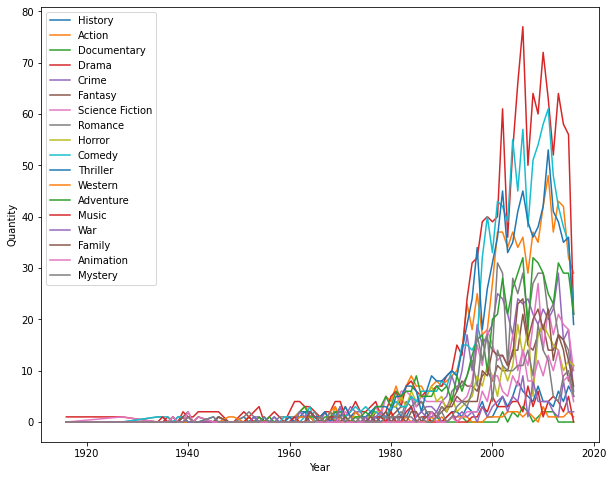

In [2310]:
plt.figure(figsize=(10,8))
ax1=plt.subplot(1,1,1)
new_genres[genres_].plot(label='genres',kind='line',ax=ax1)
# plt.title('All genres per year')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.show()

Ranking of movies genres shooting quantity

In [2311]:
genres = new_genres[genres_].sum(axis=0).sort_values(ascending=True)
genres

Documentary          20
Western              48
Music                92
War                 105
History             126
Animation           178
Mystery             256
Horror              325
Fantasy             329
Family              346
Science Fiction     412
Romance             500
Crime               502
Adventure           632
Action              866
Thriller            907
Comedy             1005
Drama              1288
dtype: int64

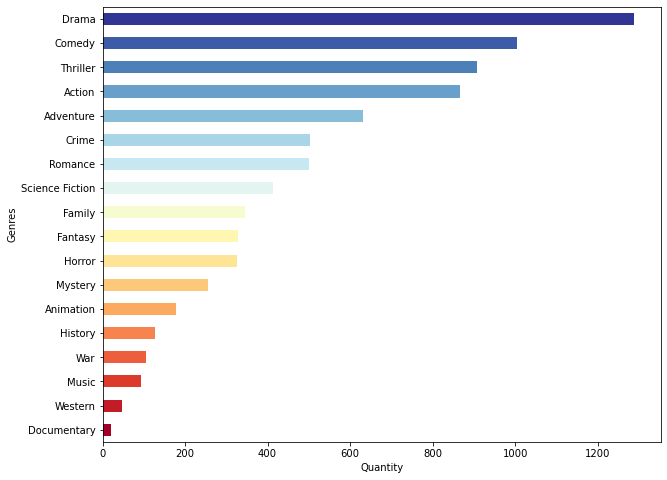

In [2312]:
plt.figure(figsize=(10,8))
colors = cm.RdYlBu(np.linspace(0,1,len(genres)))
genres.plot(kind='barh',color=colors)
# plt.title('Ranking of movie genres shooting times')
plt.xlabel('Quantity')
plt.ylabel('Genres')
plt.show()

Genres comparison (whether based on novel)
- original movie
- adapted movie

In [2313]:
new_df['based on novel'] = new_df['keywords'].str.contains('based on novel').apply(lambda x :1 if x else 0)
new_df['not based on novel'] = new_df['keywords'].str.contains('based on novel').apply(lambda x : 0 if x else 1)
genres_based = new_df[['release_year','based on novel','not based on novel']]
genres_based.head(5)

,release_year,based on novel,not based on novel
0,2009,0,1
1,2007,0,1
2,2015,1,0
3,2012,0,1
4,2012,1,0


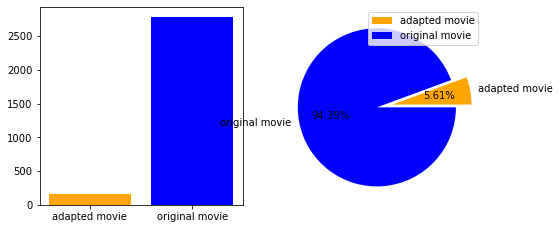

In [2314]:
novel_list = [genres_based['based on novel'].sum(axis=0),genres_based['not based on novel'].sum(axis=0)]
fig = plt.figure(figsize=(8,8))
ax1=fig.add_subplot(221)
ax1.bar(['adapted movie', 'original movie'],novel_list,color=['orange','b'])
ax2=fig.add_subplot(222)
ax2.pie(novel_list, labels = ['adapted movie', 'original movie'],colors=['orange','b'],autopct='%.2f%%',explode=[0.1,0.1])
ax2.legend(loc='best')
plt.show()

(array([0, 1]),
 [Text(0, 0, '(original movies,)'), Text(1, 0, '(adapted movies,)')])

<Figure size 720x576 with 0 Axes>

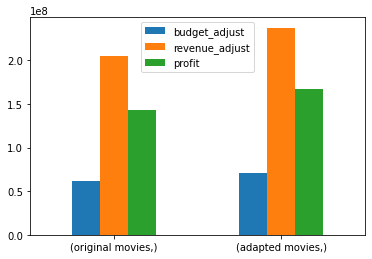

In [2315]:
new_original=new_df[['not based on novel','based on novel','budget_adjust','revenue_adjust','profit']]
original_mean=new_original.groupby('based on novel').mean()
original_mean.index = [['original movies','adapted movies']]
original_mean.drop('not based on novel',axis=1, inplace=True)
plt.figure(figsize=(10,8))
original_mean.plot(kind='bar')
# plt.title('The budget, revenue, profit of original movies and adapted movies\n') The budget, revenue, profit of original movies and adapted movies
plt.ylabel('')
plt.xticks(rotation=0)

Voting

In [2316]:
genres_df = pd.DataFrame(columns=genres_)
for i in pd.DataFrame(genres).index:
    list_=[]
    for j,t in zip(new_df["genres"],new_df["weight"]):
        if i in j:
            list_.append(t)
    genres_df[i]=pd.Series(list_)
genres_vote=genres_df.describe().T
genres_vote

,count,mean,std,min,25%,50%,75%,max
History,20.0,6.464411,0.267516,5.773975,6.366372,6.461361,6.588082,6.923243
Action,20.0,6.519742,0.484788,5.799297,6.189557,6.433307,6.892621,7.449169
Documentary,20.0,6.420000,0.096287,6.183943,6.365193,6.417787,6.464673,6.604975
Drama,20.0,6.802164,0.641739,5.958873,6.306796,6.698829,7.152146,8.025361
Crime,20.0,6.482561,0.624180,5.210850,6.206049,6.328715,6.843425,8.025361
Fantasy,20.0,6.504281,0.509860,5.777983,6.058194,6.471107,6.892621,7.329559
Science Fiction,20.0,6.486651,0.542076,5.520313,6.089067,6.396220,7.022078,7.302744
Romance,20.0,6.481419,0.377667,5.916937,6.175296,6.492239,6.668553,7.336977
Horror,20.0,6.183194,0.273663,5.687860,6.002126,6.130305,6.346315,6.787865
Comedy,20.0,6.515977,0.634347,5.791465,6.044071,6.245975,7.015616,7.735832


In [2317]:
genres_df = genres_df.T.stack().reset_index(level=1
                            ,drop=True
                            ,inplace= False
                            ).reset_index().rename(columns={"index":"genres",0:"score"})
genres_df["genres"].value_counts().sort_index()

Action             20
Adventure          20
Animation          20
Comedy             20
Crime              20
Documentary        20
Drama              20
Family             20
Fantasy            20
History            20
Horror             20
Music              20
Mystery            20
Romance            20
Science Fiction    20
Thriller           20
War                20
Western            20
Name: genres, dtype: int64

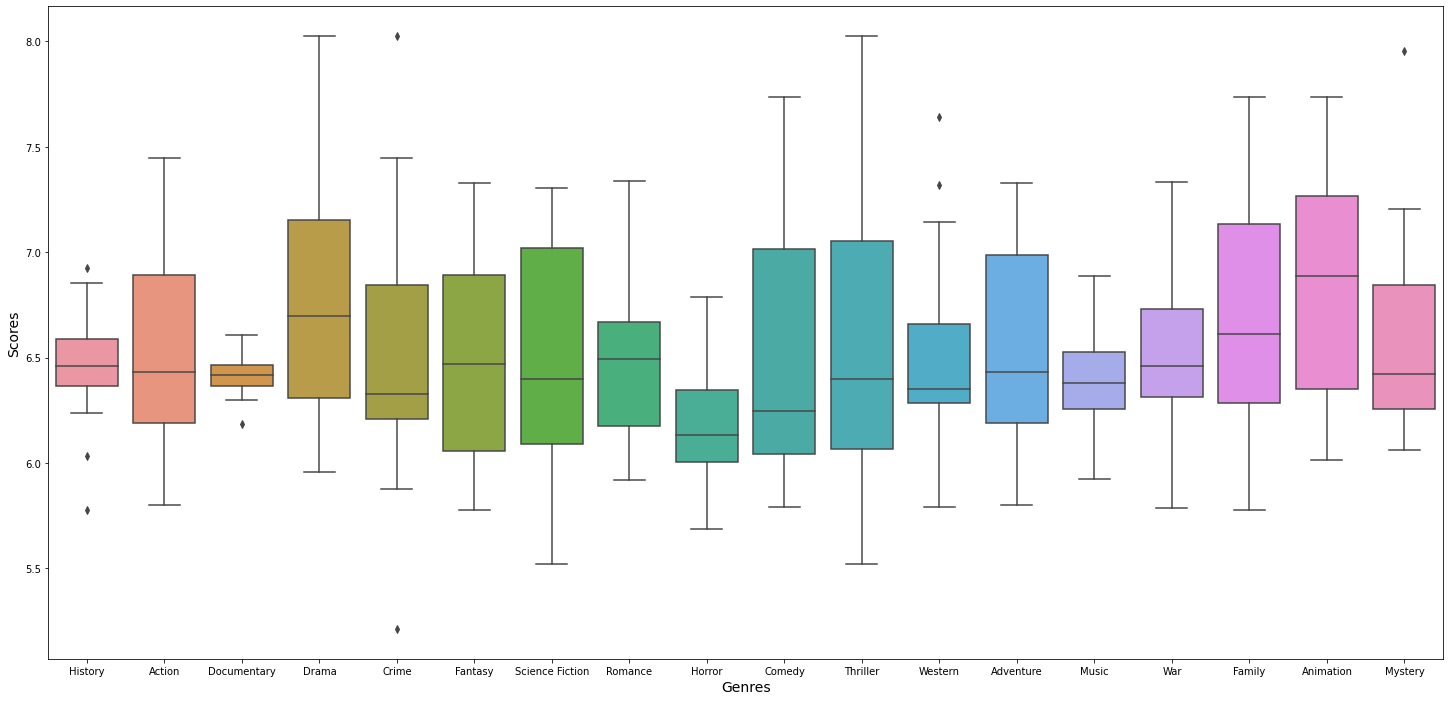

In [2318]:
plt.figure(figsize=(25,12))
sns.boxplot(x='genres',y='score', data=genres_df)
plt.xlabel(xlabel="Genres",fontsize=14)
plt.ylabel(ylabel="Scores",fontsize=14)
# plt.title('Top 10 genres with highest average movies ratings',fontsize=16,pad=20) Movie scores by genre
plt.show()

In [2319]:
genres_revenue_df = pd.DataFrame(columns=genres_)
for i in pd.DataFrame(genres).index:
    list_=[]
    for j,t in zip(new_df["genres"],new_df["revenue_adjust"]):
        if i in j:
            list_.append(t)
    genres_revenue_df[i]=pd.Series(list_)

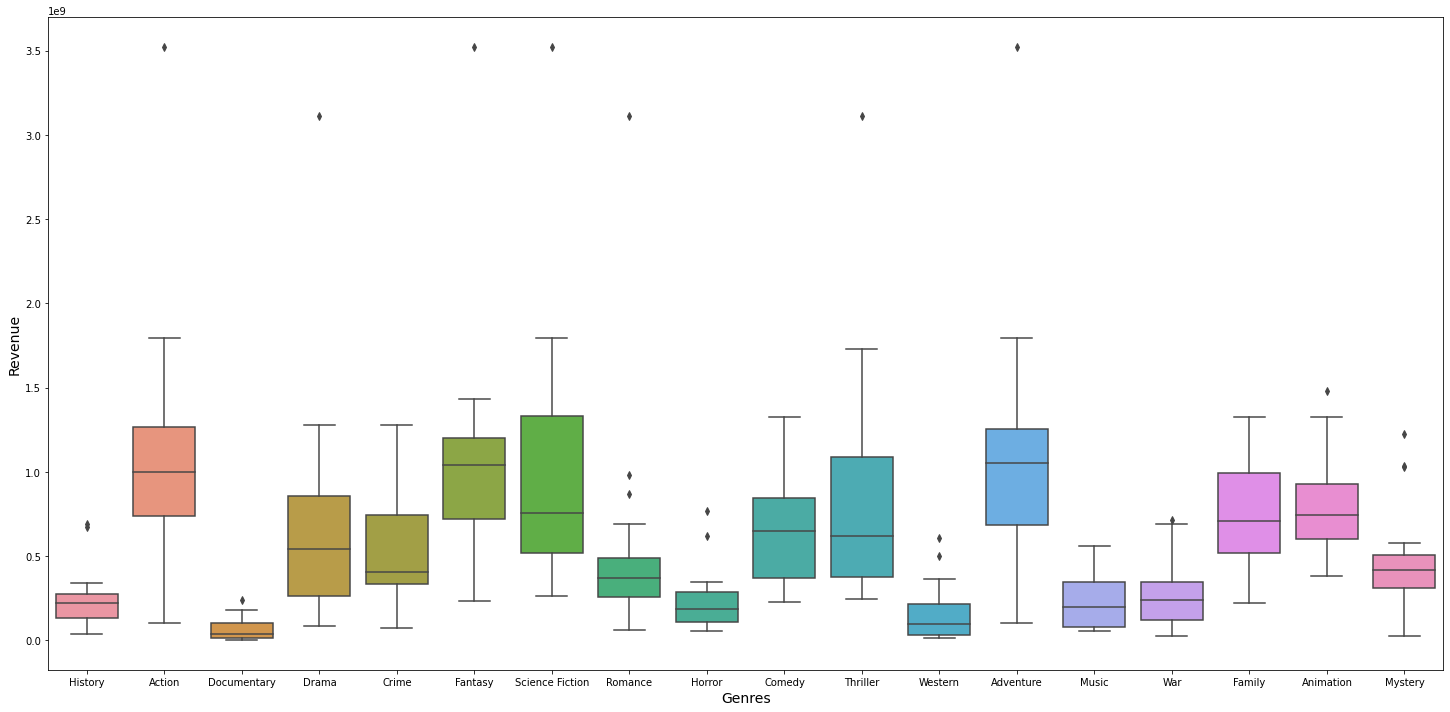

In [2320]:
plt.figure(figsize=(25,12))
sns.boxplot( data=genres_revenue_df)
plt.xlabel(xlabel="Genres",fontsize=14)
plt.ylabel(ylabel="Revenue",fontsize=14)
# plt.title('Top 10 genres with highest average movies ratings',fontsize=16,pad=20) Movie revenues by genre
plt.show()

### Countries

In [2217]:
index = 0
for i in new_df['production_countries']:
    if ',' in i:
        v = 'Cooperation' 
    else:
        v = i.split(',')[0]
    new_df.loc[index,'countries'] = v 
    index+=1

new_countries =pd.DataFrame()
new_countries['countries'] = new_df['countries'].value_counts().index
new_countries['num'] = new_df['countries'].value_counts().values
# new_countries.loc[new_countries['countries'] == 'United States of America','countries'] = 'United States'

countries_ = list(new_countries['countries'])

others = pd.DataFrame(data={
    'countries': ['others'],
    'num': [new_countries['num'][5:].sum()]
})

countries_plot = pd.concat([new_countries[:5],others])

Proportion of film production in different countries

(-1.1145363418251886, 1.309762861440394, -1.21010394916764, 1.1076129322203778)

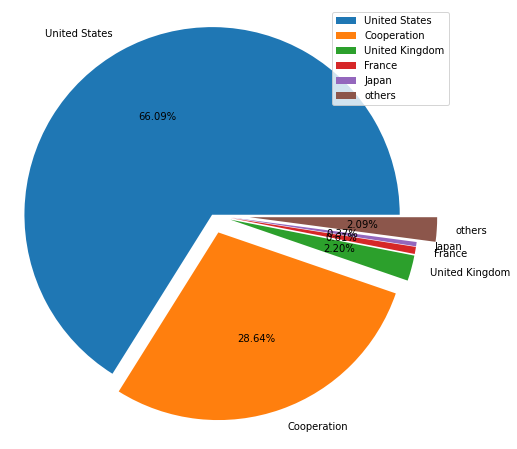

In [2218]:
plt.figure(0,figsize=(8,8))
plt.pie(countries_plot['num'],labels=countries_plot['countries'],autopct='%.2f%%',explode=[0,0.1,0.1,0.1,0.1,0.2])
plt.legend()
# plt.title('Proportion of film production in different countries')
plt.axis('equal')


In [2219]:
countries_.remove('Cooperation')
for i in countries_:  
    new_df[i]=new_df['production_countries'].str.contains(i).apply(lambda x : 1 if x else 0)
# new_df.head(5)

In [2220]:
countries_year = pd.DataFrame()
countries_year = new_df.groupby('release_year').sum()
countries_year.head(5)

,budget,id,popularity,revenue,vote_average,vote_count,release_month,budget_adjust,revenue_adjust,profit,...,South Africa,Hong Kong,New Zealand,Norway,Thailand,Fiji,Bulgaria,Russia,Brazil,Iran
release_year,,,,,,,,,,,,,,,,,,,,,
1916,385907,3059,3.232447,8394751,7.4,60,9,9.593506e+06,2.086904e+08,1.990969e+08,...,0,0,0,0,0,0,0,0,0,0
1927,92620000,19,32.351527,650422,8.0,657,1,1.442370e+09,1.012901e+07,-1.432241e+09,...,0,0,0,0,0,0,0,0,0,0
1934,325000,3078,11.871424,4500000,7.7,275,2,6.572034e+06,9.099739e+07,8.442535e+07,...,0,0,0,0,0,0,0,0,0,0
1935,609000,3080,3.898498,3202000,7.4,59,9,1.204531e+07,6.333182e+07,5.128651e+07,...,0,0,0,0,0,0,0,0,0,0
1936,1,3082,28.276480,8500000,8.1,856,2,1.949424e+01,1.657011e+08,1.657011e+08,...,0,0,0,0,0,0,0,0,0,0


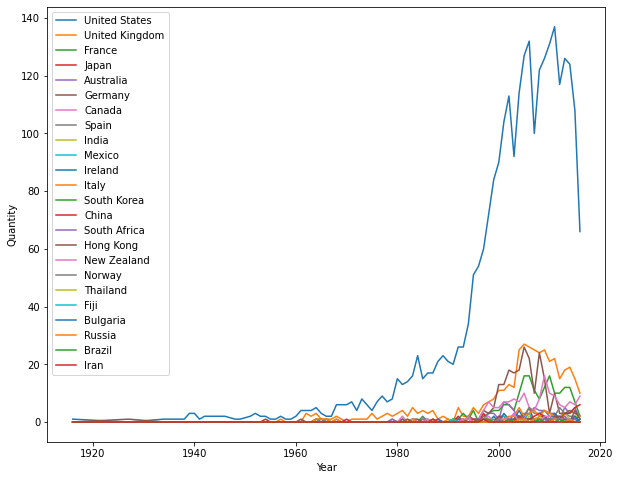

In [2221]:
plt.figure(figsize=(10,8))
ax1=plt.subplot(1,1,1)
countries_year[countries_].plot(label='countries',kind='line',ax=ax1)
# plt.title('All countries per year')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.show()

Voting

In [2222]:
new_countries = new_countries.drop(index=new_countries[new_countries['countries']=='Cooperation'].index[0])

In [2223]:
countries_df = pd.DataFrame(columns=countries_)
for i in new_countries['countries']:
    list_=[]
    for j,t in zip(new_df["production_countries"],new_df["weight"]):
        if i in j:
            list_.append(t)
    countries_df[i]=pd.Series(list_)
countries_vote = countries_df.describe().T
countries_vote

,count,mean,std,min,25%,50%,75%,max
United States,2691.0,6.420097,0.354091,5.093712,6.226820,6.346539,6.527042,8.215487
United Kingdom,419.0,6.494950,0.374389,5.210850,6.297519,6.402704,6.592029,8.025361
France,188.0,6.404976,0.269752,5.605273,6.249069,6.367420,6.479935,7.402671
Japan,38.0,6.505190,0.444846,5.715016,6.294060,6.387589,6.607536,7.820925
Australia,74.0,6.346748,0.318250,5.687860,6.201358,6.254506,6.406369,7.709191
Germany,225.0,6.425728,0.342014,5.711265,6.234935,6.345242,6.534086,8.071219
Canada,153.0,6.344677,0.322632,5.753547,6.175861,6.295547,6.422842,7.919354
Spain,40.0,6.472041,0.347611,5.897761,6.288370,6.399407,6.613049,7.485804
India,23.0,6.477720,0.327149,5.727219,6.301179,6.414650,6.551148,7.226862
Mexico,14.0,6.502228,0.284559,6.149963,6.282014,6.521716,6.596377,7.236180


In [2321]:
countries_df = countries_df.T.stack().reset_index(level=1
                            ,drop=True
                            ,inplace= False
                            ).reset_index().rename(columns={"index":"countries",0:"score"})
countries_df["countries"].value_counts().sort_index()

countries    4052
score        4052
Name: countries, dtype: int64

In [2225]:
countries_df

,countries,score
0,United States,7.118722
1,United States,6.780986
2,United States,6.311817
3,United States,7.449169
4,United States,6.194254
...,...,...
4047,Brazil,6.364772
4048,Brazil,6.188612
4049,Brazil,7.386308
4050,Brazil,6.467675


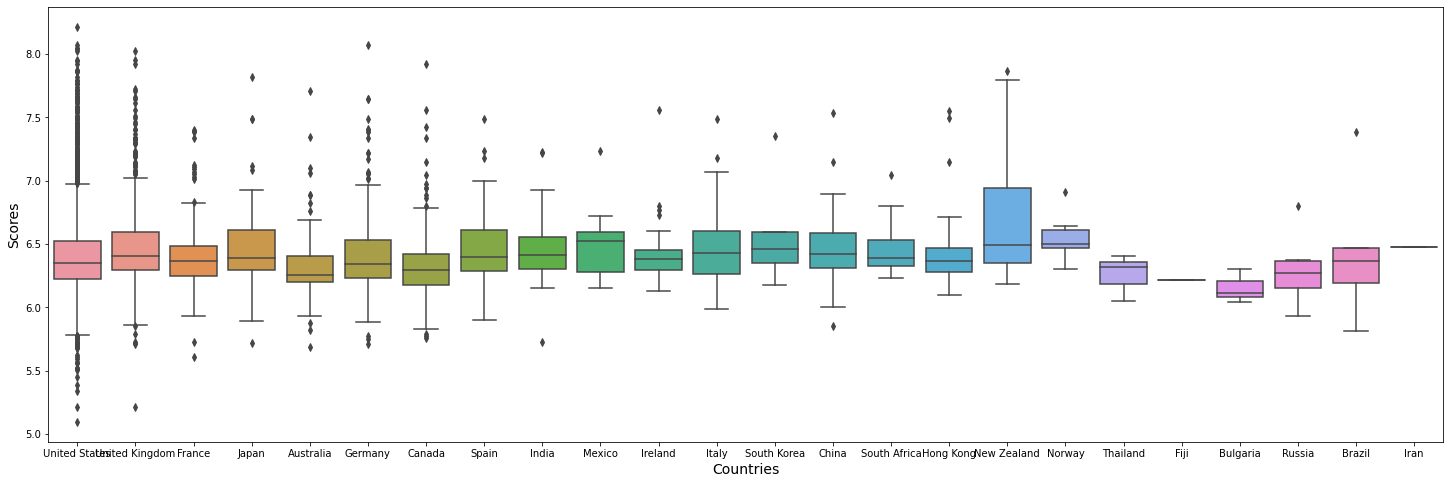

In [2226]:
plt.figure(figsize=(25,8))
sns.boxplot(x='countries',y='score', data=countries_df)
plt.xlabel(xlabel="Countries",fontsize=14)
plt.ylabel(ylabel="Scores",fontsize=14)
# plt.title('Top 10 countries with highest average movies voting scores',fontsize=16)
plt.show()


In [2227]:
countries_revenue_df = pd.DataFrame(columns=countries_)
for i in new_countries['countries']:
    list_=[]
    for j,t in zip(new_df["production_countries"],new_df["revenue_adjust"]):
        if i in j:
            list_.append(t)
    countries_revenue_df[i]=pd.Series(list_)
# countries_revenue_df.drop('Cooperation',axis=1,inplace=True)

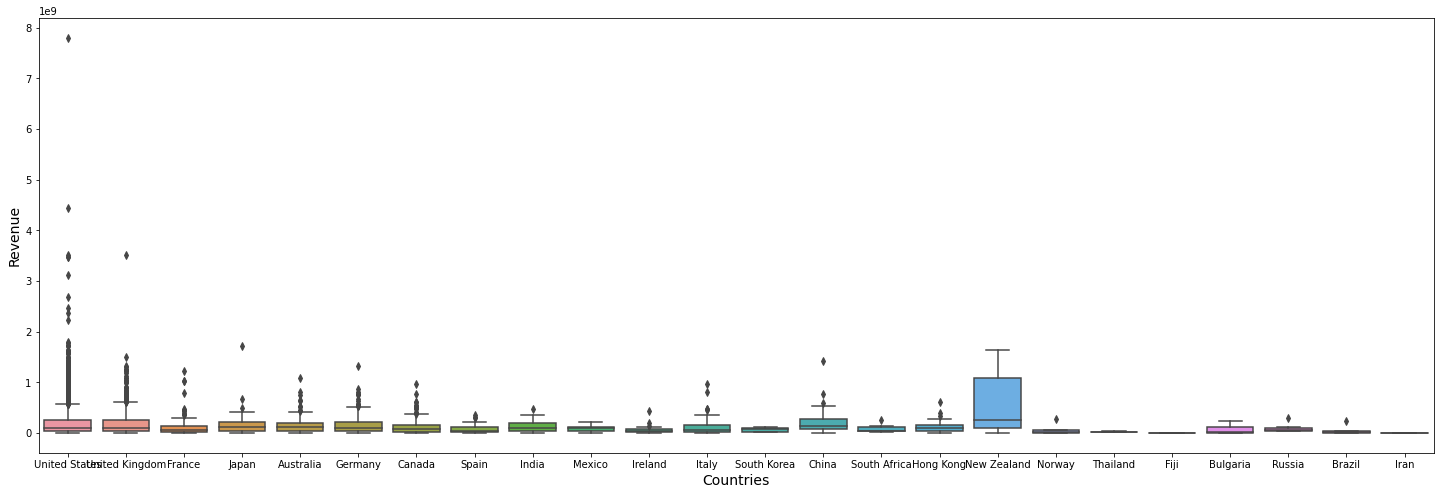

In [2228]:
plt.figure(figsize=(25,8))
sns.boxplot(data=countries_revenue_df)
plt.xlabel(xlabel="Countries",fontsize=14)
plt.ylabel(ylabel="Revenue",fontsize=14)
# plt.title('',fontsize=16,pad=20)
plt.show()


In [2229]:
countries_data = [list(i) for i in zip(new_countries['countries'],new_countries['num'])]

print(countries_data)

Map(init_opts=opts.InitOpts(width="1200px", height="1200px")).add("Movies",data_pair=countries_data ,maptype="world").set_series_opts(label_opts=opts.LabelOpts(is_show=False)).set_global_opts(
    title_opts=opts.TitleOpts(title=" d"),  
    visualmap_opts=opts.VisualMapOpts(
        max_ = 99999,
        is_piecewise=True,
        pieces =[{"max": 5, "min": 0, "label": "0-5",} ,
        {"max": 10, "min": 6, "label": "6-10",},
        {"max": 10, "min": 30, "label": "10-30",},
        {"max": 100, "min": 31, "label": "31-100",},
        {"max": 1000, "min": 101, "label": "101-1000",},
        {"max": 9999, "min": 1001, "label": "> 1000",}] 
    )
).render("Map.html")

[['United States', 1957], ['United Kingdom', 65], ['France', 18], ['Japan', 11], ['Australia', 8], ['Germany', 7], ['Canada', 7], ['Spain', 6], ['India', 5], ['Mexico', 3], ['Ireland', 3], ['Italy', 3], ['South Korea', 3], ['China', 3], ['South Africa', 2], ['Hong Kong', 2], ['New Zealand', 2], ['Norway', 2], ['Thailand', 1], ['Fiji', 1], ['Bulgaria', 1], ['Russia', 1], ['Brazil', 1], ['Iran', 1]]


'd:\\UK_Warwick_University\\Course\\CS910_Data Analytics\\Project\\movie\\Map.html'

### Companies

In [2230]:
companies_ = set()
for i in new_df['production_companies'].str.split(','):
    companies_ = set().union(i,companies_)
companies_=list(companies_)

In [2231]:
index = 0
for i in new_df['production_companies']:
    v = i.split(',')[0]
    new_df.loc[index,'companies'] = v 
    index+=1

new_companies =pd.DataFrame()
new_companies['companies'] = new_df['companies'].value_counts().index
new_companies['num'] = new_df['companies'].value_counts().values

new_companies

,companies,num
0,Paramount Pictures,225
1,Universal Pictures,219
2,Columbia Pictures,163
3,Twentieth Century Fox Film Corporation,149
4,New Line Cinema,129
...,...,...
653,Universal Pictures Corporation,1
654,Australian Film Finance Corporation,1
655,Autonomous,1
656,Boll Kino Beteiligungs GmbH & Co. KG,1


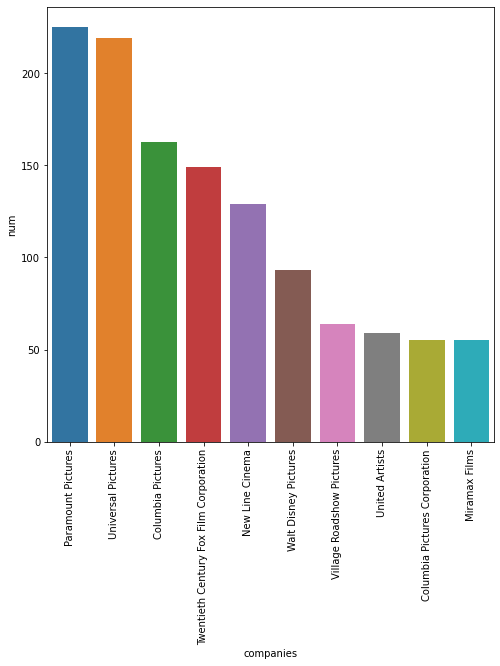

In [2232]:
plt.figure(figsize=(8,8))
sns.barplot(x='companies', y='num', data=new_companies[:10])
plt.xticks(rotation=90)
plt.show()

In [2233]:
companies_revenue=new_df.groupby("companies")["revenue_adjust"].describe()
new_companies_revenue=pd.DataFrame({"companies":companies_revenue.index
                              ,"revenue_adjust":companies_revenue["mean"]}).sort_values(by=["revenue_adjust"],ascending=False)

new_companies_revenue

,companies,revenue_adjust
companies,,
Selznick International Pictures,Selznick International Pictures,2.674215e+09
Walt Disney Productions,Walt Disney Productions,1.847527e+09
Patalex IV Productions Limited,Patalex IV Productions Limited,1.243050e+09
Lucasfilm,Lucasfilm,1.122485e+09
1492 Pictures,1492 Pictures,1.037637e+09
...,...,...
Instinctive Film,Instinctive Film,2.650203e+04
Midnight Sun Pictures,Midnight Sun Pictures,2.105586e+04
Pathe Productions,Pathe Productions,3.387125e+01


<Figure size 576x576 with 0 Axes>

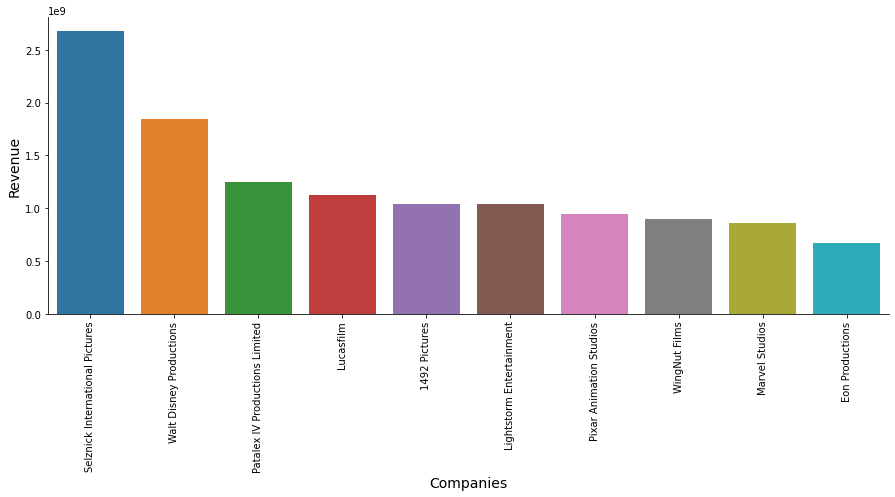

In [2234]:
plt.figure(figsize=(8,8))
sns.catplot(x='companies',y='revenue_adjust', data=new_companies_revenue[:10], kind='bar',aspect=2.5)
plt.xlabel(xlabel="Companies",fontsize=14)
plt.ylabel(ylabel="Revenue",fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [2235]:
companies_vote=new_df.groupby("companies")["weight"].describe()
new_companies_vote=pd.DataFrame({"companies":companies_vote.index
                              ,"score":companies_vote["mean"]}).sort_values(by=["score"],ascending=False)

new_companies_vote

,companies,score
companies,,
Black Bear Pictures,Black Bear Pictures,7.704141
Blue Parrot Productions,Blue Parrot Productions,7.614284
Shaw Brothers,Shaw Brothers,7.492944
Stanley Kubrick Productions,Stanley Kubrick Productions,7.444024
Lightstorm Entertainment,Lightstorm Entertainment,7.389647
...,...,...
Open Road Films (II),Open Road Films (II),5.924979
Todman,Todman,5.791465
Stoney Lake Entertainment,Stoney Lake Entertainment,5.721866


<Figure size 576x576 with 0 Axes>

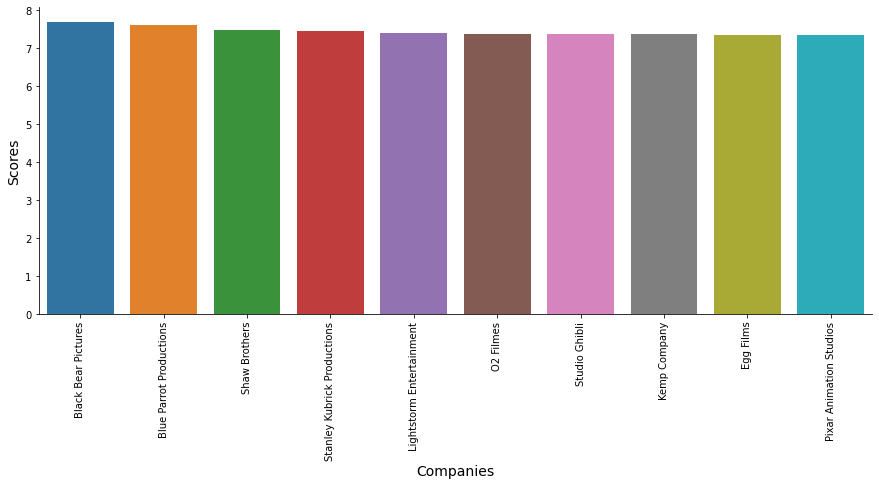

In [2236]:
plt.figure(figsize=(8,8))
sns.catplot(x='companies',y='score', data=new_companies_vote[:10], kind='bar',aspect=2.5)
plt.xlabel(xlabel="Companies",fontsize=14)
plt.ylabel(ylabel="Scores",fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [2237]:
companies_df = pd.DataFrame(columns=companies_)
for i in new_companies['companies']:
    list_=[]
    for j,t in zip(new_df["production_companies"],new_df["weight"]):
        if i in j:
            list_.append(t)
    companies_df[i]=pd.Series(list_)
companies_vote = companies_df.describe().T
companies_vote


,count,mean,std,min,25%,50%,75%,max
,229.0,6.476346,0.522548,5.210850,6.113647,6.384527,6.805413,8.025361
Geffen Pictures,2.0,6.597857,0.309864,6.378750,6.488304,6.597857,6.707411,6.816964
Lucky Monkey Pictures,2.0,6.352361,0.066018,6.305679,6.329020,6.352361,6.375702,6.399043
Morgan Creek Productions,19.0,6.316916,0.196142,5.787138,6.257970,6.304465,6.377682,6.782472
New South Wales Film & Television Office,1.0,6.490483,NaN,6.490483,6.490483,6.490483,6.490483,6.490483
...,...,...,...,...,...,...,...,...
Rogue Pictures,7.0,6.160499,0.174851,5.877735,6.043350,6.229556,6.298750,6.332005
Solaris Film,2.0,6.688494,0.485432,6.345242,6.516868,6.688494,6.860120,7.031746
The Mirisch Corporation,2.0,6.939442,0.084127,6.879955,6.909699,6.939442,6.969185,6.998929
Black Bear Pictures,3.0,6.762594,0.828701,6.143959,6.291821,6.439684,7.071912,7.704141


In [2238]:
companies_df = companies_df.T.stack().reset_index(level=1
                            ,drop=True
                            ,inplace= False
                            ).reset_index().rename(columns={"index":"companies",0:"score"})

companies_df["companies"].value_counts().sort_index()


                           229
100 Bares                    2
1492 Pictures               14
1818                         1
21 Laps Entertainment       12
                          ... 
Yash Raj Films               1
Younggu-Art Movies           1
Zentropa Entertainments      4
Zininsa Film Production      1
area japan                   1
Name: companies, Length: 658, dtype: int64

In [2239]:
companies_df = companies_df[companies_df['companies'] != ''].reset_index(drop=True)
companies_df

,companies,score
0,Geffen Pictures,6.816964
1,Geffen Pictures,6.37875
2,Lucky Monkey Pictures,6.305679
3,Lucky Monkey Pictures,6.399043
4,Morgan Creek Productions,5.787138
...,...,...
6695,The Mirisch Corporation,6.998929
6696,Black Bear Pictures,6.143959
6697,Black Bear Pictures,7.704141
6698,Black Bear Pictures,6.439684


### Language

In [2240]:
language_df = new_df[(new_df['original_language'].isin((new_df['original_language'].value_counts()[:10].index.values)))]

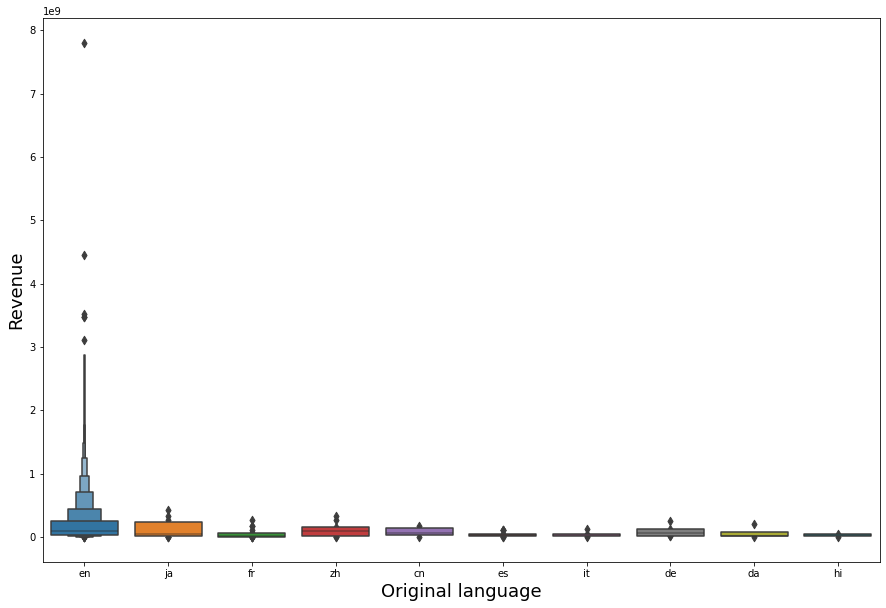

In [2241]:
plt.figure(figsize=(15,10))

sns.boxenplot(x='original_language', y='revenue_adjust',
                   data=language_df)
# plt.title("Profit by original language's movies", fontsize=20)  
plt.xlabel('Original language', fontsize=18) 
plt.ylabel('Revenue', fontsize=18) 
plt.show()

### Cast & Directors  

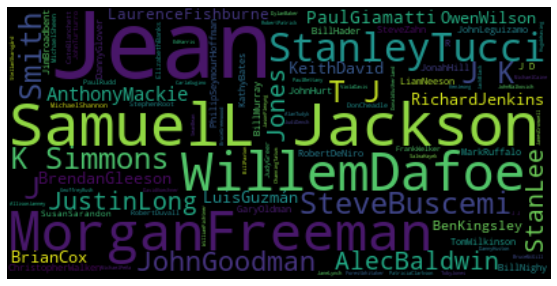

In [2242]:
cast = ''.join(i for i in new_df['cast'].str.replace(' ',''))
worldcloud =WordCloud(background_color='black',stopwords=',').generate(cast)
plt.figure(figsize=(10,5))
plt.imshow(worldcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

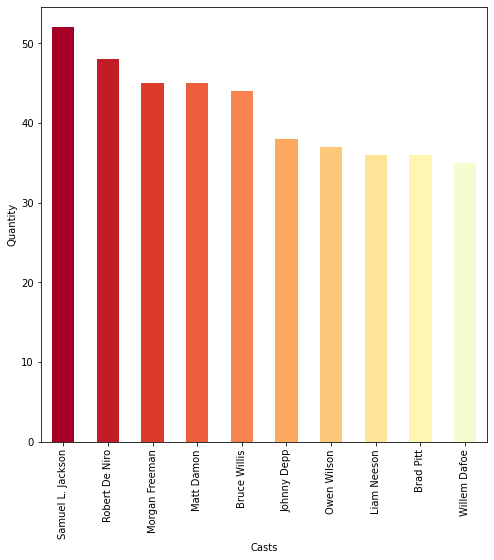

In [2243]:
cast_data = new_df['cast'].str.split(',')
list_ = []
for i in cast_data:
    list_.extend(i)
cast = pd.Series(list_).value_counts()[:20].sort_values(ascending=False).drop({' Jr.'})


plt.figure(figsize=(8,8))
cast[:10].plot(kind ='bar',color=colors)
# plt.title('Top 10 actors with the highest acting frequency')
plt.xlabel('Casts')
plt.ylabel('Quantity')
plt.show()


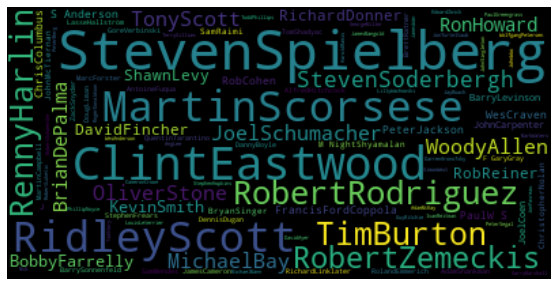

In [2244]:
director = ''
for i in new_df['director'].str.replace(' ',''):
    director +=i
    director +=' ' 

worldcloud =WordCloud(background_color='black',stopwords=',').generate(director)
plt.figure(figsize=(10,5))
plt.imshow(worldcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

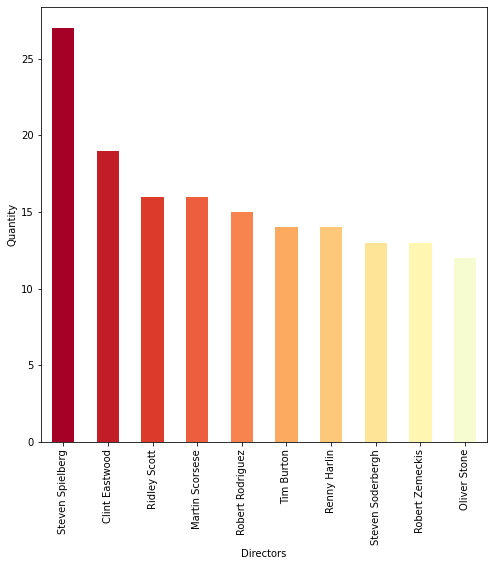

In [2245]:
director_data = new_df['director'].value_counts()[:10].sort_values(ascending=False)

plt.figure(figsize=(8,8))
director_data.plot(kind ='bar',color=colors)
# plt.title('Top 10 directors with the largest number of movies')
plt.xlabel('Directors')
plt.ylabel('Quantity')
plt.show()

### Keywords

WordCloud diagram

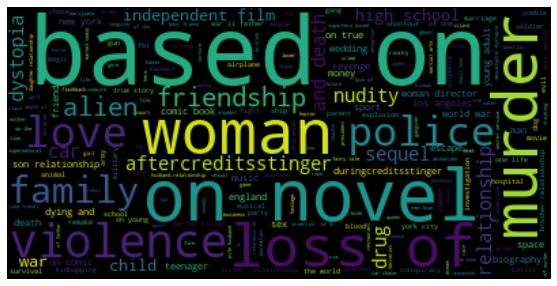

In [2246]:
keywords = ''.join(i for i in new_df['keywords'])
worldcloud =WordCloud(background_color='black',stopwords=',').generate(keywords)
plt.figure(figsize=(10,5))
plt.imshow(worldcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### Revenue & Profit

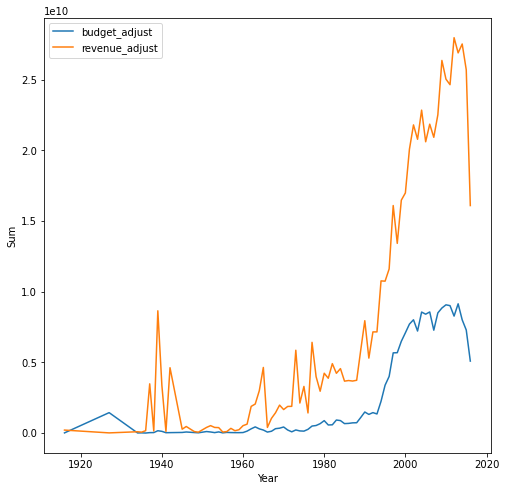

In [2322]:
plt.figure(figsize=(8, 8))
x = new_df['release_year'].value_counts().sort_index(inplace=False).index
y1 = new_df.groupby('release_year').budget_adjust.sum()
y2 = new_df.groupby('release_year').revenue_adjust.sum()
plt.plot(x, y1, label = 'budget_adjust')
plt.plot(x, y2, label = 'revenue_adjust')
plt.xlabel('Year'); plt.ylabel('Sum')
# plt.title('Sum of budget and revenue')
plt.legend()
plt.show()

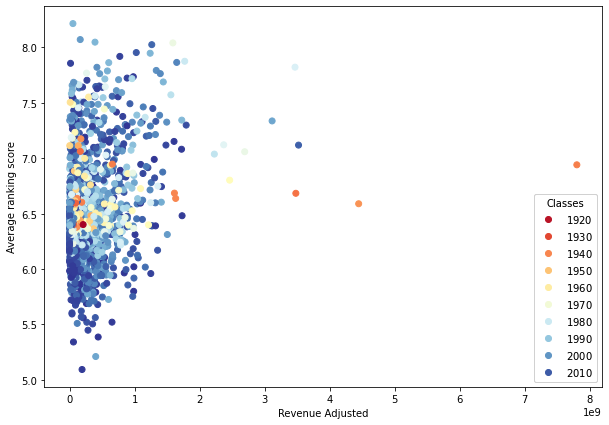

In [2323]:
fig, ax = plt.subplots(figsize=(10,7))
scatter = ax.scatter( new_df['revenue_adjust'],new_df['weight'], c =new_df['release_year'],cmap='RdYlBu', marker ='o')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Classes")
ax.add_artist(legend1)

# plt.title('Average rate against revenue')
plt.xlabel('Revenue Adjusted')
plt.ylabel('Average ranking score')
plt.show()

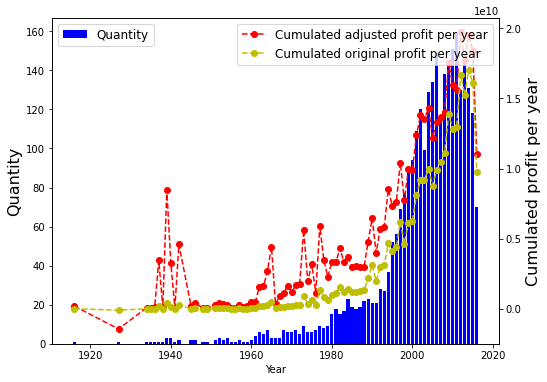

In [2334]:
fig = plt.figure(figsize=(8,6))

x = new_df['release_year'].value_counts().sort_index(inplace=False).index
y1 = new_df.groupby('release_year').profit.size()
y2 = new_df.groupby('release_year').profit.sum() # 
y3 = new_df.groupby('release_year').profit_.sum()
# 
ax1 = fig.add_subplot(1,1,1)
plt.bar(x,y1,color='b',label='Quantity')
plt.grid(False)
ax1.set_xlabel('Year')                   
ax1.set_ylabel('Quantity',fontsize=16)
ax1.legend(loc=2,fontsize=12)

#
ax2 = ax1.twinx()
plt.plot(x,y2,'ro--',label='Cumulated adjusted profit per year')
plt.plot(x,y3,'yo--',label='Cumulated original profit per year')
ax2.set_ylabel('Cumulated profit per year',fontsize=16)
ax2.legend(loc=1,fontsize=12)

plt.show()


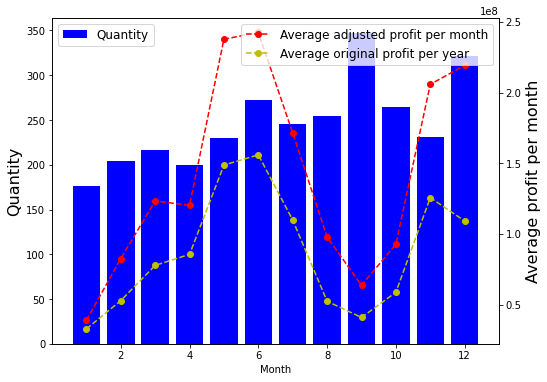

In [2327]:
fig = plt.figure(figsize=(8,6))

x = new_df['release_month'].value_counts().sort_index(inplace=False).index
y1 = new_df.groupby('release_month').profit.size()
y2 = new_df.groupby('release_month').profit.mean()  
y3 = new_df.groupby('release_month').profit_.mean()

# 
ax1 = fig.add_subplot(1,1,1)
plt.bar(x,y1,color='b',label='Quantity')
plt.grid(False)
ax1.set_xlabel('Month')                   
ax1.set_ylabel('Quantity',fontsize=16)
ax1.legend(loc=2,fontsize=12)

#
ax2 = ax1.twinx()
plt.plot(x,y2,'ro--',label='Average adjusted profit per month')
plt.plot(x,y3,'yo--',label='Average original profit per year')
ax2.set_ylabel('Average profit per month',fontsize=16)
ax2.legend(loc=1,fontsize=12)

plt.show()

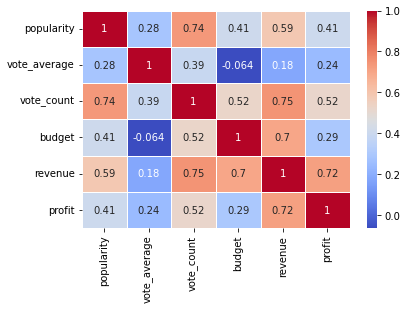

In [2251]:
corr_df = new_df[['runtime', 'popularity', 'vote_average','vote_count','budget', 'revenue','profit']].corr()

sns.heatmap(
    corr_df,
    annot=True, 
    # cmap="Blues", 
    # cmap="YlGnBu", 
    cmap="coolwarm", 
    cbar=True, 
    linewidths=0.5, 
)
plt.show()

In [2252]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) 
    df = df[[col for col in df if df[col].nunique() > 1]] #
    columnNames = list(df)
    if len(columnNames) > 8: 
        columnNames = columnNames[:8]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    # plt.suptitle('Scatter and Density Plot')
    plt.show()

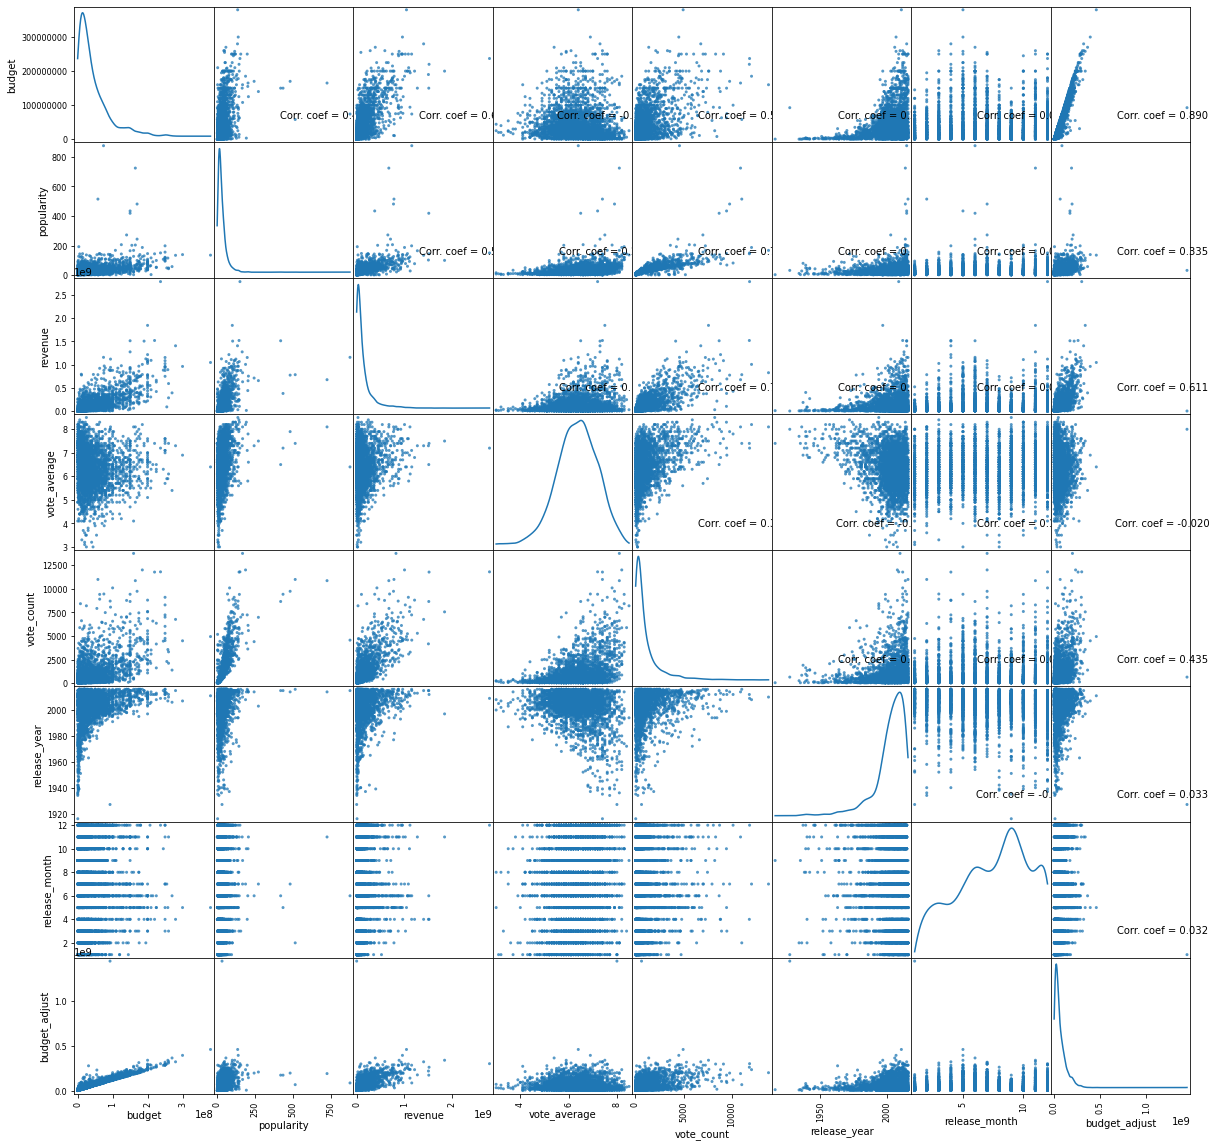

In [2253]:
plotScatterMatrix(new_df.drop('id',axis=1),20,10)

In [2254]:
new_df.columns

Index(['budget', 'genres', 'id', 'keywords', 'original_language', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'title', 'vote_average',
       'vote_count', 'cast', 'director', 'release_year', 'release_month',
       'budget_adjust', 'revenue_adjust', 'profit', 'profit_', 'weight',
       'History', 'Action', 'Documentary', 'Drama', 'Crime', 'Fantasy',
       'Science Fiction', 'Romance', 'Horror', 'Comedy', 'Thriller', 'Western',
       'Adventure', 'Music', 'War', 'Family', 'Animation', 'Mystery',
       'based on novel', 'not based on novel', 'countries', 'United States',
       'United Kingdom', 'France', 'Japan', 'Australia', 'Germany', 'Canada',
       'Spain', 'India', 'Mexico', 'Ireland', 'Italy', 'South Korea', 'China',
       'South Africa', 'Hong Kong', 'New Zealand', 'Norway', 'Thailand',
       'Fiji', 'Bulgaria', 'Russia', 'Brazil', 'Iran', 'companies'],
      dtype='object')

In [2255]:
del new_df['release_date']
del new_df['genres']
del new_df['production_countries']
del new_df['production_companies']
del new_df['keywords']
del new_df['cast']
del new_df['director']
del new_df['spoken_languages']
del new_df['original_language']
del new_df['countries']
del new_df['companies']
del new_df['profit']
del new_df['profit_']
del new_df['id']
# del new_df['budget']
# del new_df['revenue']

new_df = new_df.set_index('title')
new_df.to_csv('./movie.csv',quoting=1,index=False)

## Model Prediction

In [2256]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, BayesianRidge


In [2257]:
seed =100
split_size = 0.34

In [2258]:
def preprocess(data,y,x_to_drop=None,seed=seed,split_size=split_size):

    # data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
    y=data[y]
    if x_to_drop != None:
        X=data.drop(columns=x_to_drop)
    else:
        X=data
    X = sm.add_constant(X)
    scaler = StandardScaler()
    X_transformed = scaler.fit_transform(X)
    X = pd.DataFrame(X_transformed, columns = X.columns,index=y.index)

    return train_test_split(X, y, test_size=split_size, random_state=seed)

In [2259]:
def adjusted_r_2(y_test,y_pred,n,p):
    r2=r2_score(y_test,y_pred)
    return 1-(1-r2)*(n-1)/(n-p-1)

In [2260]:

def print_linear(coefs, names = None, sort = False):  
    if names == None:  
        names = ["X%s" % x for x in range(len(coefs))]  
    lst = zip(coefs, names)  
    if sort:  
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))  
    return " + ".join("%s * %s" % (round(coef, 3), name)  
                                   for coef, name in lst)

### Revenue  

In [2261]:
X_train, X_test, y_train, y_test=preprocess(new_df,"revenue",["revenue_adjust","budget_adjust","revenue"])

d:\App\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [2262]:
X_train.shape

(1954, 53)

In [2263]:
y_pred=np.ones(y_test.shape) * np.mean(y_train)
print("Baseline:"+ str(adjusted_r_2(y_test,y_pred,len(y_train),1)))

Baseline:-0.004446795089317002


Ridge Regression Score: 0.6811059518974855
Ridge Regression r2 Score: 0.6897600146468112


Text(0, 0.5, 'Mean Squared Error')

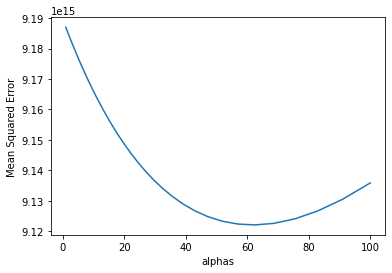

In [2264]:
alphas=np.logspace(0,2,50)
ridge = RidgeCV(alphas=alphas,store_cv_values=True).fit(X_train, y_train)
y_pred=ridge.predict(X_test)
print("Ridge Regression Score:",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))
print("Ridge Regression r2 Score:",r2_score(y_test, y_pred))
plt.plot(alphas,np.apply_along_axis(np.mean,0,ridge.cv_values_))
# plt.title("alpha scores",fontsize=15)
plt.xlabel("alphas")
plt.ylabel("Mean Squared Error")

Lasso Regression Score: 0.6869230453912563
Lasso Regression r2 Score: 0.695419245388319


Text(0, 0.5, 'Mean Squared Error')

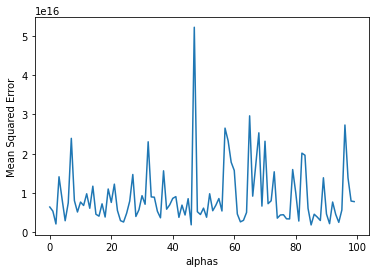

In [2265]:
alphas=np.logspace(0,2,50)
lasso = LassoCV(alphas=alphas,cv=100).fit(X_train, y_train)
y_pred=lasso.predict(X_test)
print("Lasso Regression Score:",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))
print("Lasso Regression r2 Score:",r2_score(y_test, y_pred))
plt.plot(np.apply_along_axis(np.mean,0,lasso.mse_path_))
# plt.title("alpha scores",fontsize=15)
plt.xlabel("alphas")
plt.ylabel("Mean Squared Error")

In [2266]:
alphas=np.logspace(0,2,50)
br = BayesianRidge().fit(X_train, y_train)
y_pred=br.predict(X_test)
print("BayesianRidge Regression Adjusted r2 Score :",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))
print("BayesianRidge Regression r2 Score:",r2_score(y_test, y_pred))


BayesianRidge Regression Adjusted r2 Score : -0.03193691790207409
BayesianRidge Regression r2 Score: -0.003932485414204212


### Voting scores


In [2267]:
X_train, X_test, y_train, y_test=preprocess(new_df,"weight",['weight'])

d:\App\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Ridge Regression Score: 0.7999336386711736
Ridge Regression r2 Score: 0.8055678679968702


Text(0, 0.5, 'Mean Squared Error')

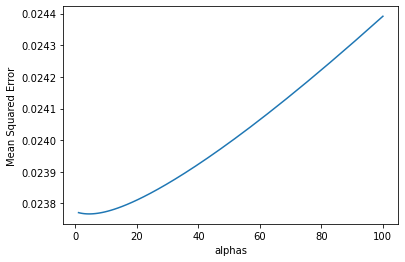

In [2268]:
alphas=np.logspace(0,2,50)
model = RidgeCV(alphas=alphas,store_cv_values=True).fit(X_train, y_train)
y_pred=model.predict(X_test)
print("Ridge Regression Score:",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))
print("Ridge Regression r2 Score:",r2_score(y_test, y_pred))
# print('Voting_score = '+ print_linear(model.coef_,names=names))
plt.plot(alphas,np.apply_along_axis(np.mean,0,model.cv_values_))
# plt.title("alpha scores",fontsize=15)
plt.xlabel("alphas")
plt.ylabel("Mean Squared Error")

Lasso Regression Adjusted r2 Score : -0.03321078355162643
Lasso Regression r2 Score: -0.004113705673828516


Text(0, 0.5, 'Mean Squared Error')

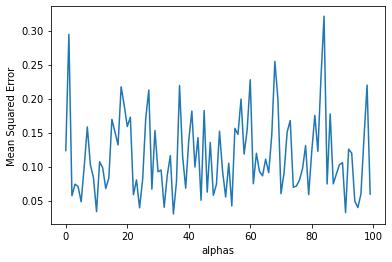

In [2269]:
alphas=np.logspace(0,2,50)
lasso = LassoCV(alphas=alphas,cv=100).fit(X_train, y_train)
y_pred=lasso.predict(X_test)
print("Lasso Regression Adjusted r2 Score :",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))
print("Lasso Regression r2 Score:",r2_score(y_test, y_pred))
plt.plot(np.apply_along_axis(np.mean,0,lasso.mse_path_))
# plt.title("alpha scores",fontsize=15)
plt.xlabel("alphas")
plt.ylabel("Mean Squared Error")

In [2270]:
alphas=np.logspace(0,2,50)
br = BayesianRidge().fit(X_train, y_train)
y_pred=br.predict(X_test)
print("BayesianRidge Regression Adjusted r2 Score :",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))
print("BayesianRidge Regression r2 Score:",r2_score(y_test, y_pred))
# plt.plot(np.apply_along_axis(np.mean,0,br.lambda_))
# # plt.title("alpha scores",fontsize=15)
# plt.xlabel("alphas")
# plt.ylabel("Mean Squared Error")

BayesianRidge Regression Adjusted r2 Score : 0.8045504100527462
BayesianRidge Regression r2 Score: 0.8100546227752751


### Clustering 

KMeans

In [2271]:
from sklearn.cluster import KMeans

In [2272]:
scaler = StandardScaler()
X = scaler.fit_transform(new_df)
kmeans_10 = KMeans(n_clusters=10).fit(X)
kmeans_10.score(X)

-123382.20697514304

In [2273]:
k_means = range(1, 31)
scores = []

for k in k_means:
    # print('Starting k = {} fitting'.format(k))
    model = KMeans(k).fit(X)
    score = model.score(X)
    scores.append(-score)

Text(0, 0.5, 'SSE')

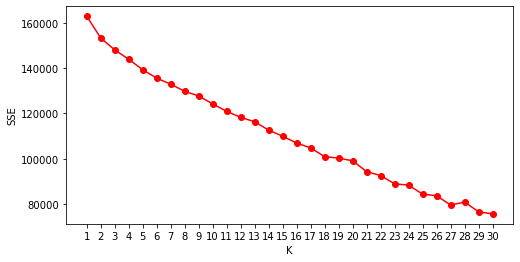

In [2274]:
x = range(1, 31)
plt.figure(figsize=(8, 4))
plt.plot(x, scores, marker='o',c='r')
plt.xticks(x)
plt.xlabel('K')
plt.ylabel('SSE')

In [2275]:
X_clustered = kmeans_10.fit_predict(X)
C = kmeans_10.cluster_centers_
# C

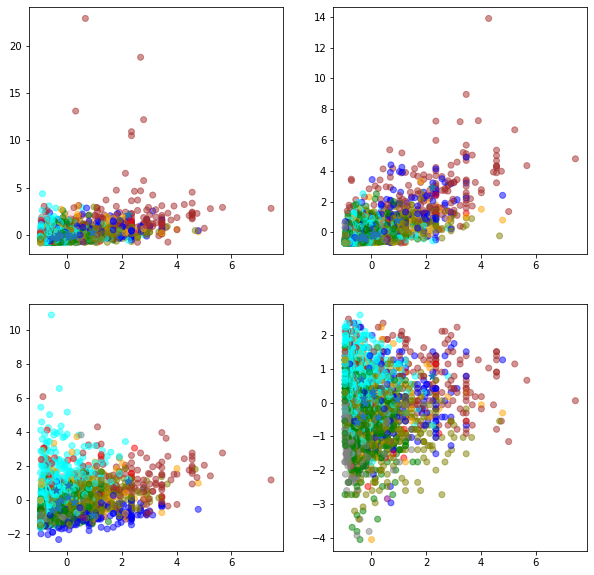

In [2276]:
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b' , 3: 'gray', 4:'brown', 5:'orange', 6:'cyan', 7:'olive', 8:'purple', 9:'pink', 10:'grey'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

fig = plt.figure(figsize = (10,10))
ax1=fig.add_subplot(2,2,1)                    
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

ax1.scatter(X[:,0],X[:,1], c= label_color, alpha=0.5) 
ax1.scatter(C[:,0],C[:,1],marker='*',s=60)
ax2.scatter(X[:,0],X[:,2], c= label_color, alpha=0.5) 
ax2.scatter(C[:,0],C[:,2],marker='*',s=60)
ax3.scatter(X[:,0],X[:,3], c= label_color, alpha=0.5) 
ax3.scatter(C[:,0],C[:,3],marker='*',s=60)
ax4.scatter(X[:,0],X[:,4], c= label_color, alpha=0.5) 
ax4.scatter(C[:,0],C[:,4],marker='*',s=60)

# for i in range(k):
#     plt.annotate(str(i + 1),(C[i,0],C[i,1]))


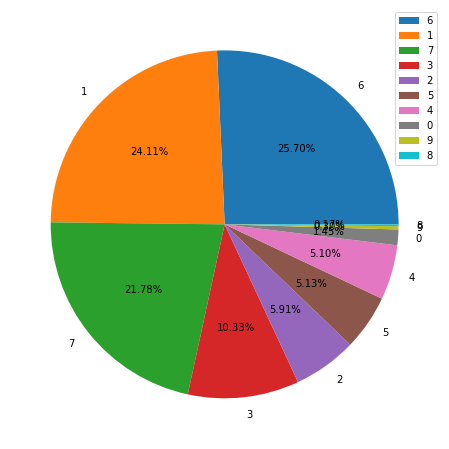

In [2277]:
new_df['cluster_Kmeans'] = X_clustered
cluster_df = new_df['cluster_Kmeans'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(cluster_df.values,labels=cluster_df.index,autopct='%.2f%%')
plt.legend(loc='best')

Hierarchical Agglomerative Clustering

In [2278]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


In [2279]:
hac_cls = AgglomerativeClustering(n_clusters=10,linkage='ward')
X_clustered = hac_cls.fit(X).fit_predict(X)

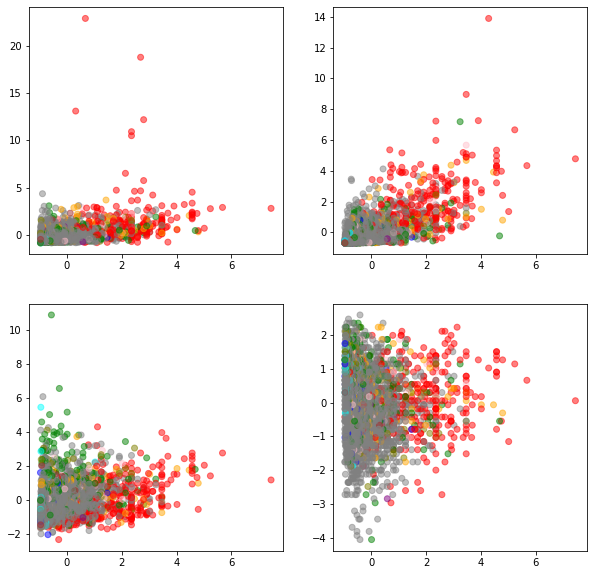

In [2280]:
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b' , 3: 'gray', 4:'brown', 5:'orange', 6:'cyan', 7:'olive', 8:'purple', 9:'pink', 10:'grey'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

fig = plt.figure(figsize = (10,10))
ax1=fig.add_subplot(2,2,1)                    
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

ax1.scatter(X[:,0],X[:,1], c= label_color, alpha=0.5) 
ax2.scatter(X[:,0],X[:,2], c= label_color, alpha=0.5) 
ax3.scatter(X[:,0],X[:,3], c= label_color, alpha=0.5) 
ax4.scatter(X[:,0],X[:,4], c= label_color, alpha=0.5) 

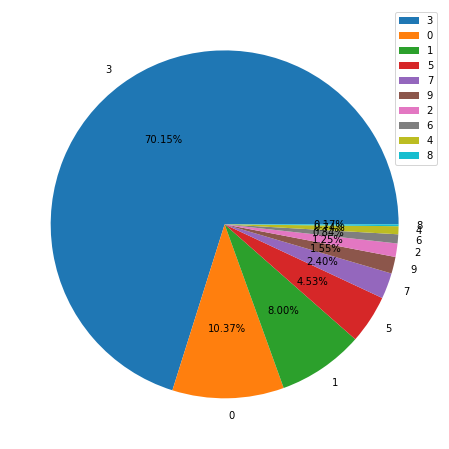

In [2281]:
new_df['cluster_hac'] = X_clustered
cluster_df = new_df['cluster_hac'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(cluster_df.values,labels=cluster_df.index,autopct='%.2f%%')
plt.legend(loc='best')

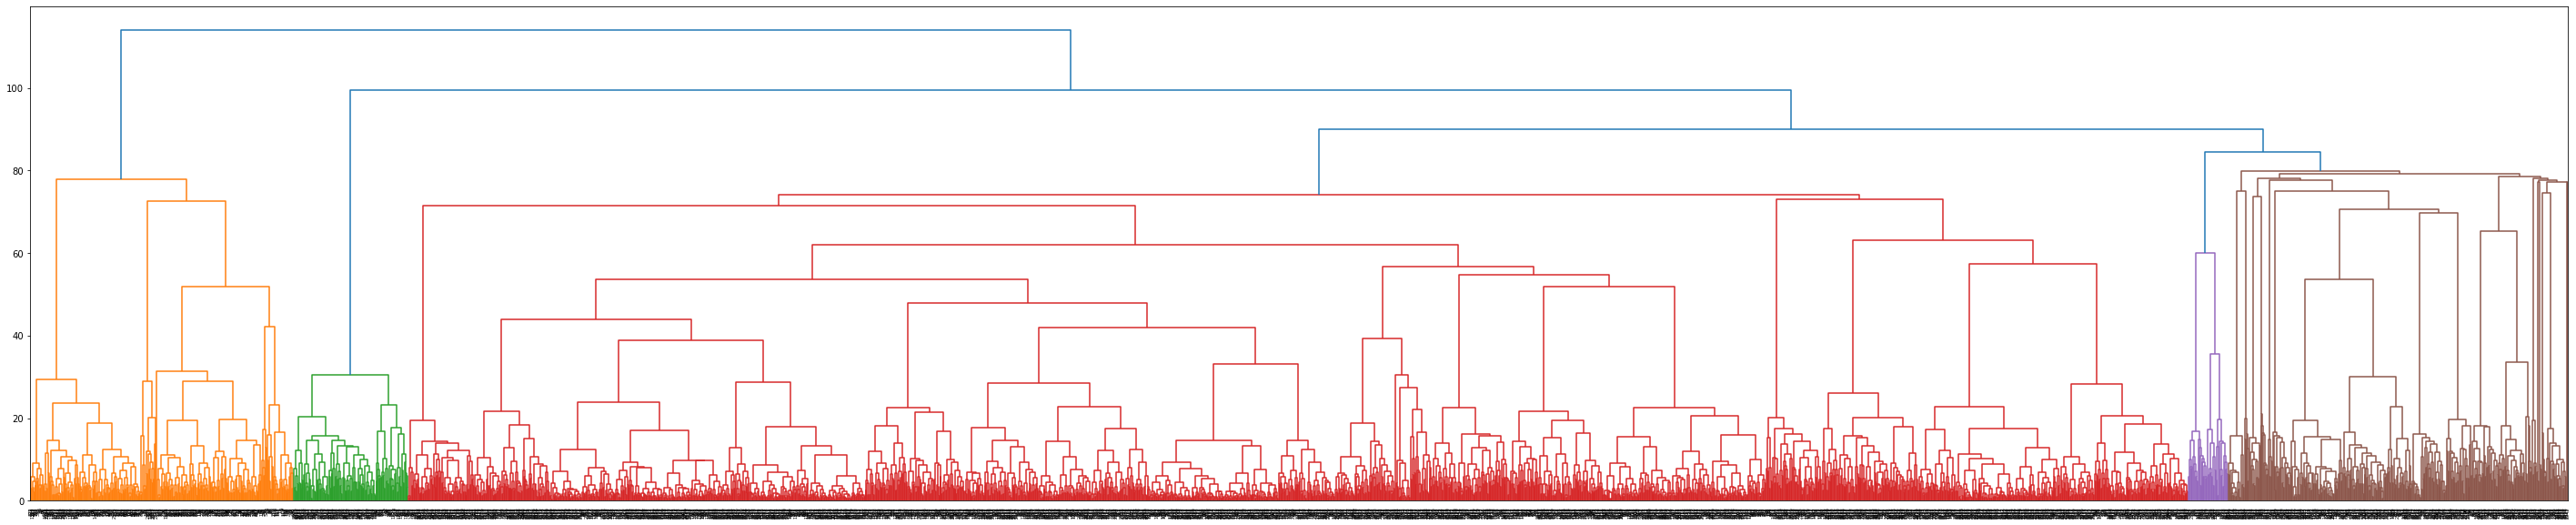

In [2282]:
plt.figure(figsize=(50, 10))  
dend = dendrogram(linkage(X, method='ward'))  
plt.xticks(rotation=90)
plt.show()


In [2283]:
new_df.to_csv('./movie_predict.csv',quoting=1,index=False)